In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import joblib

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, plot_roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score, plot_roc_curve, roc_auc_score, accuracy_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from imblearn.over_sampling import RandomOverSampler

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS

In [2]:
data = pd.read_csv('../Data/GTA_clean.csv')

data.head(2)

,business_id,name,city,state,stars,attributes,categories,user_id,review_stars,text,year
0,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,Toronto,ON,3.0,"{'WiFi': ""u'no'"", 'BikeParking': 'True', 'Rest...","Juice Bars & Smoothies, Food, Restaurants, Fas...",fd25NWbvLdNFJV_MoAljIg,4.0,Pretty solid vegan spot. Had a rice bowl there...,2017
1,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,Toronto,ON,3.0,"{'WiFi': ""u'no'"", 'BikeParking': 'True', 'Rest...","Juice Bars & Smoothies, Food, Restaurants, Fas...",AyxTBqPJjYqlY55vfNfB2Q,5.0,"What a great spot for a delicious, healthy lun...",2015


In [4]:
data['text'].head()

0    Pretty solid vegan spot. Had a rice bowl there...
1    What a great spot for a delicious, healthy lun...
2    I really do love Bolt Fresh Bar. I've gone the...
3    The vibe: Clean, bright vegetarian take out!\n...
4    I went here once to get the protein bowl and i...
Name: text, dtype: object

In [5]:
data['review_stars'].value_counts()

4.0    96211
5.0    93998
3.0    52797
1.0    31497
2.0    29522
Name: review_stars, dtype: int64

In [6]:
# Create negative reviews to contrast with postive reviews in order to identify certain key words
onestar = data[data['review_stars'] == 1.0]
twostar = data[data['review_stars'] == 2.0]
negative_reviews = [onestar, twostar]
negative_reviews = pd.concat(negative_reviews)
print(negative_reviews.shape)
negative_reviews.head(2)

(61019, 11)


,business_id,name,city,state,stars,attributes,categories,user_id,review_stars,text,year
18,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,Toronto,ON,3.0,"{'WiFi': ""u'no'"", 'BikeParking': 'True', 'Rest...","Juice Bars & Smoothies, Food, Restaurants, Fas...",kwfobAMMN9-5JSxp35F7mA,1.0,I have never thrown food out; I paid nearly $1...,2016
26,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,Toronto,ON,3.0,"{'WiFi': ""u'no'"", 'BikeParking': 'True', 'Rest...","Juice Bars & Smoothies, Food, Restaurants, Fas...",YmijSqoQqecaYYabEjA_UQ,1.0,The most miserable people on earth work here. ...,2017


In [7]:
# Instantiate count vectorizer
cvec = CountVectorizer(stop_words='english')

In [8]:
X = negative_reviews['text']
y = negative_reviews['review_stars']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

# Fit & transform the vectorizer 
cvec_fit = cvec.fit_transform(X_train)

# Transform
Xcvec_test = cvec.transform(X_test)

In [9]:
XCV = pd.DataFrame(cvec_fit.toarray(), 
                          columns=cvec.get_feature_names())

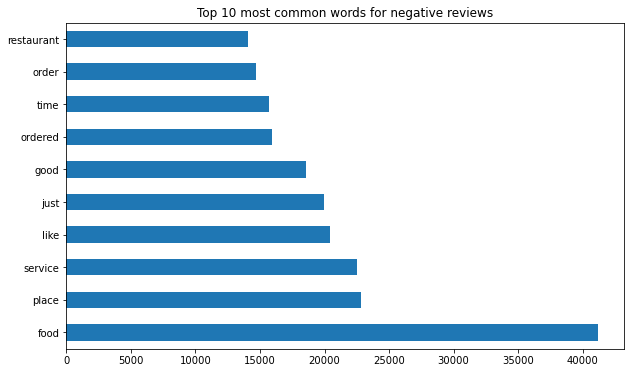

In [13]:
# plot top occuring negative words
plt.figure(figsize=(10, 6))
plt.xlabel('words')
plt.ylabel('counts')
plt.subplot(title='Top 10 most common words for negative reviews')
XCV.sum().sort_values(ascending = False).head(10).plot(kind = 'barh');

In [13]:
# Transforming using our fitted cvec and converting the result to a DataFrame
negative_words = pd.DataFrame(cvec.transform(negative_reviews['text']).todense(),
                       columns=cvec.get_feature_names())

top_neg = negative_words.sum(axis = 0).sort_values(ascending = False).head(150)
negative_pd = pd.DataFrame(data=top_neg)
top_neg = negative_words[negative_pd.index]
top_neg.drop(columns=['food','place','service','like', 'just', 'good', 'ordered', 'time', 'order', 'restaurant'], inplace = True)

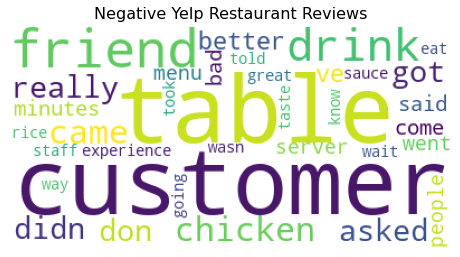

In [14]:
# plot the WordCloud image                      
wordcloud_neg = WordCloud(background_color="white", min_font_size =10).generate(' '.join(top_neg))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_neg)
plt.title('Negative Yelp Restaurant Reviews', fontsize=16, y=1.01)
plt.axis("off");

In [3]:
# Creating positive reviews
fourstar = data[data['review_stars'] == 4.0]
fivestar = data[data['review_stars'] == 5.0]
positive_reviews = [fourstar, fivestar]
positive_reviews = pd.concat(positive_reviews)
print(positive_reviews.shape)
positive_reviews.head(2)

(190209, 11)


,business_id,name,city,state,stars,attributes,categories,user_id,review_stars,text,year
0,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,Toronto,ON,3.0,"{'WiFi': ""u'no'"", 'BikeParking': 'True', 'Rest...","Juice Bars & Smoothies, Food, Restaurants, Fas...",fd25NWbvLdNFJV_MoAljIg,4.0,Pretty solid vegan spot. Had a rice bowl there...,2017
3,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,Toronto,ON,3.0,"{'WiFi': ""u'no'"", 'BikeParking': 'True', 'Rest...","Juice Bars & Smoothies, Food, Restaurants, Fas...",75DUiVsWkGZRW--zySVORA,4.0,"The vibe: Clean, bright vegetarian take out!\n...",2014


In [4]:
# Instantiate count vectorizer
cvecp = CountVectorizer(stop_words='english')

Xp = positive_reviews['text']
yp = positive_reviews['review_stars']

Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp,
                                                    yp,
                                                    test_size=0.33,
                                                    stratify=yp,
                                                    random_state=42)

In [5]:
# Fit & transform the vectorizer 
cvec_fitp = cvecp.fit_transform(Xp_train)

In [6]:
# Transform
Xcvecp_test = cvecp.transform(Xp_test)

XCVp = pd.DataFrame(cvec_fitp.toarray(), 
                          columns=cvecp.get_feature_names())

In [ ]:
# unable to plot - keeps restrarting - try again using other code
# plot top occuring positive words
plt.figure(figsize=(10, 6))
plt.xlabel('words')
plt.ylabel('counts')
plt.subplot(title='Top 10 most common words for positive reviews')
XCVp.sum().sort_values(ascending = False).head(10).plot(kind = 'barh');

In [ ]:
# Transforming using our fitted cvec and converting the result to a DataFrame
positive_words = pd.DataFrame(cvecp.transform(positive_reviews['text']).todense(),
                       columns=cvecp.get_feature_names())

top_pos = positive_words.sum(axis = 0).sort_values(ascending = False).head(150)
positive_pd = pd.DataFrame(data=top_pos)
top_pos = negative_words[positive_pd.index]
top_pos.drop(columns=['food','place','service','like', 'just', 'good', 'ordered', 'time', 'order', 'restaurant'], inplace = True)

In [ ]:
# plot the WordCloud image                      
wordcloud_pos = WordCloud(background_color="white", min_font_size =10).generate(' '.join(top_pos))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_pos)
plt.title('Positive Yelp Restaurant Reviews', fontsize=16, y=1.01)
plt.axis("off");